# MLlib: Clustering and Dimensionality Reduction

[Introduction to Spark with Python, by Jose A. Dianes](http://jadianes.github.io/spark-py-notebooks)

In this notebook we will use Spark's machine learning library [MLlib](https://spark.apache.org/docs/latest/mllib-guide.html) to perform [**K-means Clustering**](https://en.wikipedia.org/wiki/K-means_clustering) over our network attacks datasets. We will use the complete [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) datasets in order to test Spark capabilities with large datasets. 

With k-means clustering we aim to partition our `n` observations (i.e. network interactions in our dataset) into `k` clusters in which each observation belongs to the cluster with the nearest mean. An important part of using k-Means clustering is to determine the right value for `k` or number of clusters. In order to do that we will sample our dataset and iterate through different possible values. Once we have one that works well, we will use it to cluster the complete dataset.

Once we have our data clustered, we will do two things. First we will use dimensionality reduction to obtain a two dimensional dataset that we can represent visually. Then we will use our knowledge of Spark SQL and data frames from previous notebooks in order to explore each of the obtained clusters in terms of its features.  

At the time of processing this notebook, our Spark cluster contains:  

- Eight nodes, with one of them acting as master and the rest as workers.  
- Each node contains 8Gb of RAM, with 6Gb being used for each node.  
- Each node has a 2.4Ghz Intel dual core processor.  
- Running Apache Spark 1.4.1.  

## Getting the data and creating the RDD

As we said, this time we will use the complete dataset provided for the [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html), containing nearly half million nework interactions. The file is provided as a Gzip file that we will download locally. Remember that the file must be accessible to every worker in our Spark cluster (in our case we use [NFS](https://en.wikipedia.org/wiki/Network_File_System)).    

In [1]:
import urllib
f = urllib.urlretrieve ("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz", "kddcup.data.gz")

In [2]:
data_file = "./kddcup.data.gz"
raw_data = sc.textFile(data_file)

print "Train data size is {}".format(raw_data.count())

Train data size is 4898431


The [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) also provide test data that we will load in a separate RDD.  

In [3]:
ft = urllib.urlretrieve("http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz", "corrected.gz")

In [4]:
test_data_file = "./corrected.gz"
test_raw_data = sc.textFile(test_data_file)

print "Test data size is {}".format(test_raw_data.count())

Test data size is 311029


## Unsupervised learning with K-Means Clustering

Firs of all, we prepare the data for clustering input. The data contains non-numeric features, and we want to exclude them since k-means works just with numeric features. These are the first three and the last column in each data row that is the label. 

In order to do that, we define a function that we apply to the *RDD* as a `Spark` **transformation** by using `map`. The **action** that actually retrieves the data is `values`. Remember that we can apply as many transofmrations as we want without making `Spark` start any processing. Is is when we trigger an action when all the transformations are applied.  

In [5]:
from numpy import array

def parse_interaction(line):
    """
    Parses a network data interaction.
    """
    line_split = line.split(",")
    clean_line_split = [line_split[0]]+line_split[4:-1]
    return (line_split[-1], array([float(x) for x in clean_line_split]))

parsed_data = raw_data.map(parse_interaction)
parsed_data_values = parsed_data.values().cache()

We will also standardise our data as we have done so far when performing distance-based clustering.

In [6]:
from time import time
from pyspark.mllib.feature import StandardScaler

standardizer = StandardScaler(True, True)

t0 = time()
standardizer_model = standardizer.fit(parsed_data_values)
tt = time() - t0

standardized_data_values = standardizer_model.transform(parsed_data_values)
print "Data standardized in {} seconds".format(round(tt,3))

Data standardized in 308.888 seconds


And now we are ready to perform k-means clustering. The call to `KMeans.train` triggers the clustering process and returns a list of cluster centroids as well as a model que can use to assign a point to a cluster by calling `predict`. This can be seen in the `error` function declared bellow. There are other parameters for the `train` function, that are explained in the [Spark reference](http://spark.apache.org/docs/latest/mllib-clustering.html#k-means). In our case we will set three of the, the maximum number of iterations for the algorithms, the number of runs, and how do we want to initialise the cluster centroids for the iterative clustering process. 

We also need to determine a good value for K (the number of clusters for k-means). We will do this visually. We will try with a range of values from 5 to 200, and plot their *cost function* by calling `KMeansModel.computeCost()` for each clustering result. This process will take a while (in the order of minutes). Each time a new value of K has been tried you will see some output printed out. If you want to skip the whole process, you can change the list of values in the for loop to just the best value we have found after this block.

In [10]:
from pyspark.mllib.clustering import KMeans
from math import sqrt

kmeans_model = {}
cost = {}

# sample data so the process ends in a reasonable amount of time
# if you have a really powerful cluster, you can skip sampling
standardized_data_values_sample = standardized_data_values.sample(False, .1, 1234)

    
for k_value in [5, 10, 20, 40, 80, 120, 160, 200]:    
    c_t0 = time()
    kmeans_model[k_value] = KMeans.train(
            standardized_data_values_sample, 
            k_value, 
            maxIterations=20, 
            runs=10, 
            initializationMode="random"
    )
    c_tt = time() - c_t0

    w_t0 = time()
    cost[k_value] = kmeans_model[k_value].computeCost(standardized_data_values_sample)
    w_tt = time() - w_t0
    
    print "K={}, cost={}, clustered in {} seconds, Cost calculated in {} seconds".format(
        k_value, cost[k_value], round(c_tt,3), round(w_tt,3))


K=5, cost=13925173.0774, clustered in 127.986 seconds, Cost calculated in 75.817 seconds
K=10, cost=12690468.3591, clustered in 165.513 seconds, Cost calculated in 76.243 seconds
K=20, cost=11906003.3641, clustered in 207.67 seconds, Cost calculated in 75.278 seconds
K=40, cost=10693477.5776, clustered in 271.452 seconds, Cost calculated in 74.855 seconds
K=80, cost=6305833.21914, clustered in 382.217 seconds, Cost calculated in 75.535 seconds
K=120, cost=5070507.67962, clustered in 471.605 seconds, Cost calculated in 76.267 seconds
K=160, cost=4483636.09054, clustered in 553.414 seconds, Cost calculated in 76.276 seconds
K=200, cost=4018187.25798, clustered in 632.657 seconds, Cost calculated in 76.087 seconds


Now we build a [Pandas data frame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) that we will use to plot the WSSSE values.

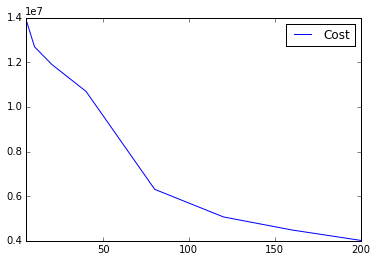

In [11]:
%matplotlib inline

import pandas as pd

kmeans_results = pd.DataFrame(
    {'Cost' : cost.values()},
    index = cost.keys()
).sort_index()

kmeans_results.plot()

We know that Cost will tend to decrease as far as we increase the number of clusters `k`, but at some point the benefit doesn't improve the clustering result regarding how well the centroids represent our sample distribution. In this case seems that `k=80` might be a good value.   

So let's use this value and cluster the **complete** dataset.

In [13]:
t0 = time()
clusters = KMeans.train(
        standardized_data_values, 
        80, 
        maxIterations=15, 
        runs=10, 
        initializationMode="random"
)
tt = time() - t0

print "Data clustered in {} seconds".format(round(tt,3))

Data clustered in 2305.673 seconds


## Visualising clusters with the help of PCA

In this section we want to do two things. First we want to visualise the clusters in a two dimensional space. By doing so we will get a feeling of cluster sizes and proximity. The second thing we want to do is to find out the main discriminant variables in our dataset. [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) will help to get both things done.

*Currently PCA is not available for pySpark.*

## Explaining the biggest clusters using Spark SQL

We will end up this exploratory data analyisis with Spark by having a look at tag composition and feature values for the five bigger clusters. 

The first thing we need to do is to add the cluster ID to each sample, so later on we can query by that value. We proceed as follows.